In [ ]:
#!pip install --upgrade fsspec # kaggle.com only
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 2.1MB 6.9MB/s 
     |████████████████████████████████| 225kB 49.9MB/s 
     |████████████████████████████████| 3.3MB 26.4MB/s 
     |████████████████████████████████| 901kB 55.7MB/s 
     |████████████████████████████████| 245kB 51.8MB/s 
     |████████████████████████████████| 112kB 41.1MB/s 


In [ ]:
#!pip install --upgrade git+https://github.com/intake/filesystem_spec

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from tqdm.notebook import tqdm
from IPython.display import clear_output
from datasets import load_dataset

import torch
import random
import torch.nn as nn
from sklearn.metrics import accuracy_score

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config, get_linear_schedule_with_warmup


Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

(array([4666.,    0., 5362.,    0., 1304.,    0., 2159.,    0., 1937.,
         572.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

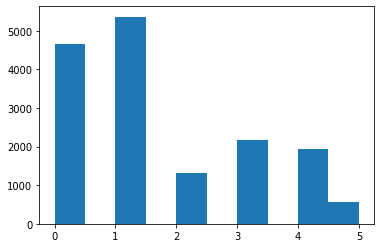

In [ ]:
plt.hist(emotion_dataset["train"]["label"])

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 5

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer(text, max_length=self.max_length, padding="max_length",return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output["input_ids"], 
            "mask": tokenizer_output["attention_mask"],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation") # validation
test_dataset = TweetDataset("test")
print("Train dataset", len(train_dataset))
print("Validation dataset", len(valid_dataset))
print("Test dataset", len(test_dataset))

Train dataset 16000
Validation dataset 2000
Test dataset 2000


In [ ]:
batch_size = 80 # Задай batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Let's see what is in the first batch
next(iter(train_loader))

{'input_ids': tensor([[[   72,  3505,  4203,  ..., 50256, 50256, 50256]],
 
         [[   72,  1254,   588,  ..., 50256, 50256, 50256]],
 
         [[   72,  3521,   256,  ..., 50256, 50256, 50256]],
 
         ...,
 
         [[   72,  7342,   257,  ..., 50256, 50256, 50256]],
 
         [[   72,  1254,   340,  ..., 50256, 50256, 50256]],
 
         [[   72,  3221, 13502,  ..., 50256, 50256, 50256]]]),
 'mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]],
 
         ...,
 
         [[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]]]),
 'target': tensor([4, 4, 0, 0, 3, 4, 5, 1, 4, 1, 1, 0, 1, 0, 1, 2, 5, 1, 1, 0, 1, 0, 3, 3,
         0, 1, 3, 1, 0, 0, 5, 0, 0, 1, 0, 3, 0, 4, 1, 0, 4, 3, 0, 0, 0, 1, 1, 1,
         0, 3, 2, 4, 0, 2, 1, 2, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 3, 4, 1, 4, 2, 2,
         1, 1, 0, 0, 1, 1, 0, 2])}

In [ ]:
next(iter(train_loader))['input_ids'].shape

torch.Size([80, 1, 128])

In [ ]:
next(iter(train_loader))['mask'].shape

torch.Size([80, 1, 128])

In [ ]:
next(iter(train_loader))['target'].shape

torch.Size([80])

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
set(emotion_dataset["train"]["label"]) # labels of dataset

{0, 1, 2, 3, 4, 5}

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    past_key_values=None,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6,
    resid_pdrop = 0.5, #The dropout probability for all fully connected layers in the embeddings, encoder, and pooler.
    attn_pdrop = 0.5 # The dropout ratio for the attention.
)

In [ ]:
model_0 = GPT2ForSequenceClassification(config=config) # GPT2 для классификации текста

In [ ]:
# look at the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_0.to(device)
model.eval()

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.5, inplace=False)
          (resid_dropout): Dropout(p=0.5, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.5, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.5, inplace=False)
          (resid_dropout): Dropout(p=0.5, inplace=False)
        )
      

Подготовь оптимайзер и критерий:

In [ ]:
num_epochs = 20
lr = 2e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
total_steps = len(train_loader) * num_epochs
optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
tokens = tokenizer(emotion_dataset["train"]["text"][0],max_length=128,padding="max_length", return_tensors="pt") # Получи токены из датасета
print(tokens.keys())
mask = tokens['attention_mask'] # Получи маску из датасета
labels =   torch.tensor([1]).unsqueeze(0)
output = model_0(**tokens.to(device), labels=labels.to(device)) # Посмотри на аутпут

dict_keys(['input_ids', 'attention_mask'])


In [ ]:
mask.shape

torch.Size([1, 128])

In [ ]:
output.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'attentions'])

In [ ]:
output.loss.item()  # loss

1.9886231422424316

In [ ]:
output.logits # logits

tensor([[-0.9554, -0.0948,  0.1410,  0.4269,  0.1587,  0.4017]],
       device='cuda:0', grad_fn=<IndexBackward>)

In [ ]:
len(train_loader)

200

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

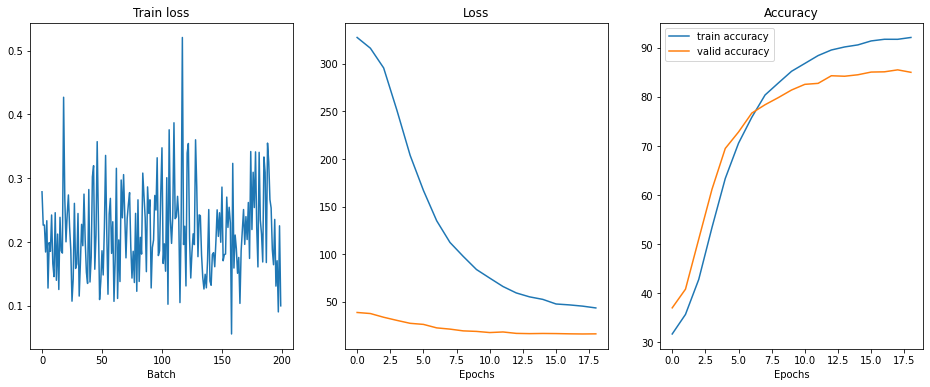


Epoch: 20 | Time: 10m 46s
Train Loss: 0.21655938170850278,Train Acc: 92.35625,Valid Loss: 0.6481699824333191,Valid Acc: 85.3


In [ ]:
clip = 1.0
best_valid_loss = float('inf')

train_history = []
valid_history = []
train_history_accuracy = []
valid_history_accuracy = []
# Train loop
for epoch in range(num_epochs):
    model_0.train()
    history = []
    train_loss = 0
    train_acc = 0
    start_time = time.time()
    for i, batch in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        inputs = batch["input_ids"].squeeze(1).to(device)
        labels = batch["target"].to(device)
        
        attention_masks = batch["mask"].squeeze(1).to(device)
        output = model_0(input_ids=inputs, attention_mask=attention_masks)
        loss = criterion(output.logits, labels)
        preds = torch.argmax(output.logits, dim=1).cpu().numpy()
        train_acc += accuracy_score(labels.cpu().numpy(), preds)*100
        train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        
        # Move logits and labels to CPU
      
        history.append(loss.cpu().data.numpy())
        
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader)):
            inputs = batch["input_ids"].squeeze(1).to(device)
            labels = batch["target"].to(device)
            attention_masks = batch["mask"].squeeze(1).to(device)
            outputs = model_0(input_ids=inputs, attention_mask=attention_masks)
            
            loss = criterion(outputs.logits, labels)
            
            valid_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
            valid_acc += accuracy_score(labels.cpu().numpy(), preds)*100
            
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model_0.state_dict(), 'bbest-val-model.pt')
            if (i+1)%10==0:
                fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

                clear_output(True)
                ax[0].plot(history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Train loss')
                plt.legend()
                if train_history is not None:
                    ax[1].plot(train_history, label='general train history')
                    ax[1].set_xlabel('Epochs')
                    ax[1].set_title('Loss')
                    plt.legend()
                if valid_history is not None:
                    ax[1].plot(valid_history, label='general valid history')
                    plt.legend()
                ax[2].plot(train_history_accuracy, label='train accuracy')
                ax[2].set_xlabel('Epochs')
                ax[2].plot(valid_history_accuracy, label='valid accuracy')
                ax[2].set_title('Accuracy')
                plt.legend()
                plt.show()
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    train_history_accuracy.append(train_acc / len(train_loader))
    valid_history_accuracy.append(valid_acc / len(valid_loader))
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Train Acc: {train_acc / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
       


In [ ]:
valid_acc / len(valid_loader)

85.3

In [ ]:
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs = batch["input_ids"].squeeze(1).to(device)
        labels = batch["target"]
        attention_masks = batch["mask"].squeeze(1).to(device)
        output = model_0(input_ids=inputs, attention_mask=attention_masks)
        preds = torch.argmax(output.logits, dim=1).cpu().numpy()
        test_acc += accuracy_score(labels.cpu().numpy(), preds)*100
print(f"Test Acc: {test_acc / len(test_loader)}")


Test Acc: 84.35


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
    sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1324, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 1324 (delta 71), reused 70 (delta 30), pack-reused 1203
Receiving objects: 100% (1324/1324), 213.79 MiB | 28.75 MiB/s, done.
Resolving deltas: 100% (834/834), done.


In [ ]:
from bertviz import model_view
#from transformers import GPT2Tokenizer, GPT2Model

In [ ]:
def call_html():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [ ]:
text = emotion_dataset["train"]["text"][11] #tokenizer.decode(result.cpu().flatten().numpy(), skip_special_tokens=True)
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True).to(device)
input_ids = inputs['input_ids']
attention = model_0(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
text = emotion_dataset["train"]["text"][11] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)
print(text)
print(tokens)

i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter
['i', 'Ġdo', 'Ġfeel', 'Ġthat', 'Ġrunning', 'Ġis', 'Ġa', 'Ġdivine', 'Ġexperience', 'Ġand', 'Ġthat', 'Ġi', 'Ġcan', 'Ġexpect', 'Ġto', 'Ġhave', 'Ġsome', 'Ġtype', 'Ġof', 'Ġspiritual', 'Ġencounter']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


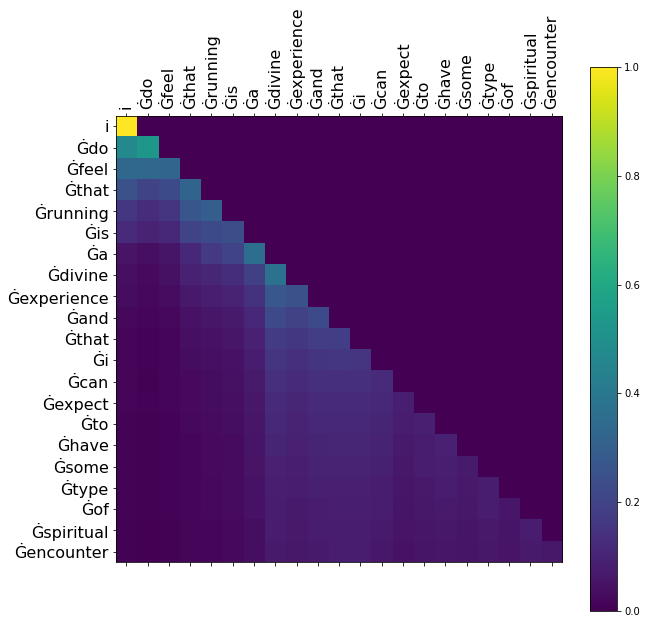

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
seed = 43

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi

Tue May  4 08:24:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6,
    resid_pdrop = 0.5, #The dropout probability for all fully connected layers in the embeddings, encoder, and pooler.
    attn_pdrop = 0.5 # The dropout ratio for the attention.
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 15
lr = 2e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
total_steps = len(train_loader) * num_epochs
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
train_history

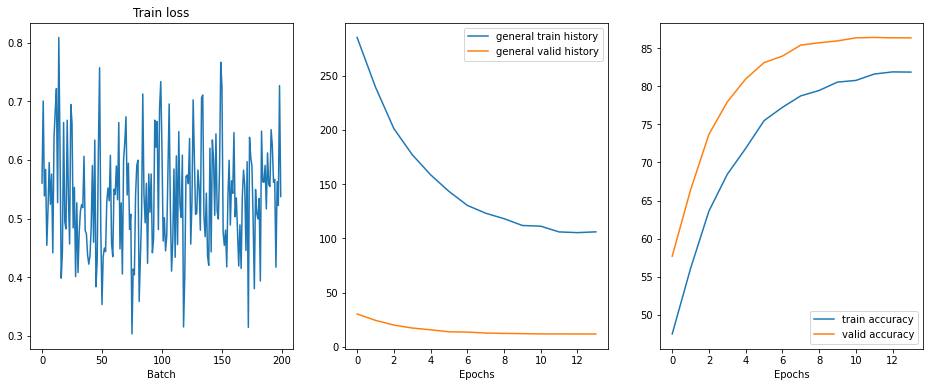


Epoch: 15 | Time: 7m 54s
Train Loss: 0.5368282504379749,Train Acc: 81.475,Valid Loss: 0.4729927921295166,Valid Acc: 86.35


In [ ]:
#from tqdm.notebook import tqdm
#from IPython.display import clear_output

train_history = []
valid_history = []
train_history_accuracy = []
valid_history_accuracy = []
clip = 1

best_valid_loss = float('inf')
# Train loop
for epoch in range(num_epochs):
    model_1.train()
    history = []
    train_loss = 0
    train_acc = 0
    start_time = time.time()
    for i, batch in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        inputs = batch["input_ids"].squeeze(1).to(device)
        labels = batch["target"].to(device)
        
        attention_masks = batch["mask"].squeeze(1).to(device)
        output = model_1(input_ids=inputs, attention_mask=attention_masks)
        
        loss = criterion(output.logits, labels)
        preds = torch.argmax(output.logits, dim=1).cpu().numpy()
        train_acc += accuracy_score(labels.cpu().numpy(), preds)*100
        train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model_1.parameters(), clip)
        optimizer.step()
        scheduler.step()
        # Move logits and labels to CPU
        #logits = logits.detach().cpu().numpy()
        history.append(loss.cpu().data.numpy())
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader)):
            inputs = batch["input_ids"].squeeze(1).to(device)
            labels = batch["target"].to(device)
            attention_masks = batch["mask"].squeeze(1).to(device)
            outputs = model_1(input_ids=inputs, attention_mask=attention_masks)
            #loss = outputs.loss
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            valid_acc += accuracy_score(labels.cpu().numpy(), preds)*100
            # Move logits and labels to CPU
            
            end_time = time.time()

            # Plot loss curves.
            if (i+1)%10==0:
                fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

                clear_output(True)
                ax[0].plot(history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Train loss')
                if train_history is not None:
                    ax[1].plot(train_history, label='general train history')
                    ax[1].set_xlabel('Epochs')
                    ax[1].legend()
                if valid_history is not None:
                    ax[1].plot(valid_history, label='general valid history')
                    ax[1].legend()
                ax[2].plot(train_history_accuracy, label='train accuracy')
                ax[2].set_xlabel('Epochs')
                ax[2].plot(valid_history_accuracy, label='valid accuracy')
                plt.legend()
                plt.show()
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model_1.state_dict(), 'model_1_best-val-model.pt')
            
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    train_history_accuracy.append(train_acc / len(train_loader))
    valid_history_accuracy.append(valid_acc / len(valid_loader))
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Train Acc: {train_acc / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")



In [ ]:
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs = batch["input_ids"].squeeze(1).to(device)
        labels = batch["target"]
        attention_masks = batch["mask"].squeeze(1).to(device)
        output = model_1(input_ids=inputs, attention_mask=attention_masks)
        preds = torch.argmax(output.logits, dim=1).cpu().numpy()
        #pred= torch.where(output <=0.5, 0., 1.)
        
        test_acc += accuracy_score(labels.cpu().numpy(), preds)*100
print(f"Test Acc: {test_acc / len(test_loader)}")


Test Acc: 86.95


In [ ]:
best_model = model_1.to(device)
best_model.load_state_dict(torch.load('model_1_best-val-model.pt'))
test_acc = 0
best_model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs = batch["input_ids"].squeeze(1).to(device)
        labels = batch["target"]
        attention_masks = batch["mask"].squeeze(1).to(device)
        output = best_model(input_ids=inputs, attention_mask=attention_masks)
        preds = torch.argmax(output.logits, dim=1).cpu().numpy()
        #pred= torch.where(output <=0.5, 0., 1.)
        
        test_acc += accuracy_score(labels.cpu().numpy(), preds)*100

best_model_accuracy = test_acc / len(test_loader)   
print(f"Test Acc: {best_model_accuracy}")



Test Acc: 86.35


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset["train"]["text"][11] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

print(text)
print(tokens)

i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter
['i', 'Ġdo', 'Ġfeel', 'Ġthat', 'Ġrunning', 'Ġis', 'Ġa', 'Ġdivine', 'Ġexperience', 'Ġand', 'Ġthat', 'Ġi', 'Ġcan', 'Ġexpect', 'Ġto', 'Ġhave', 'Ġsome', 'Ġtype', 'Ġof', 'Ġspiritual', 'Ġencounter']


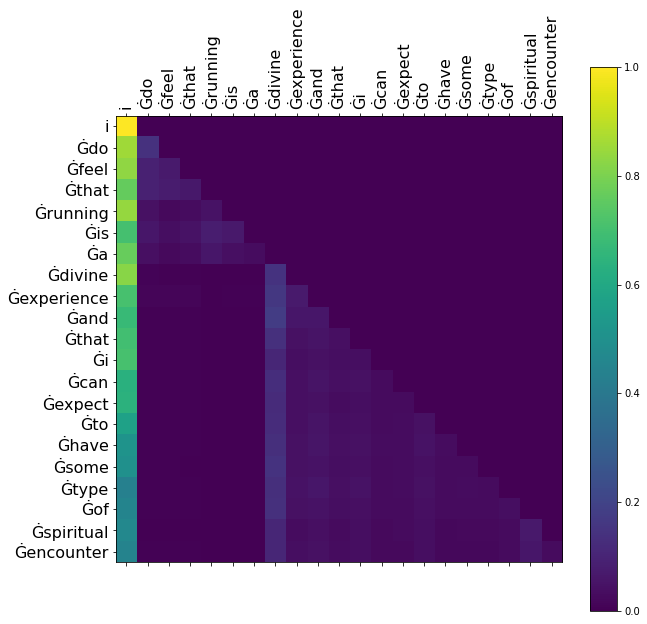

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

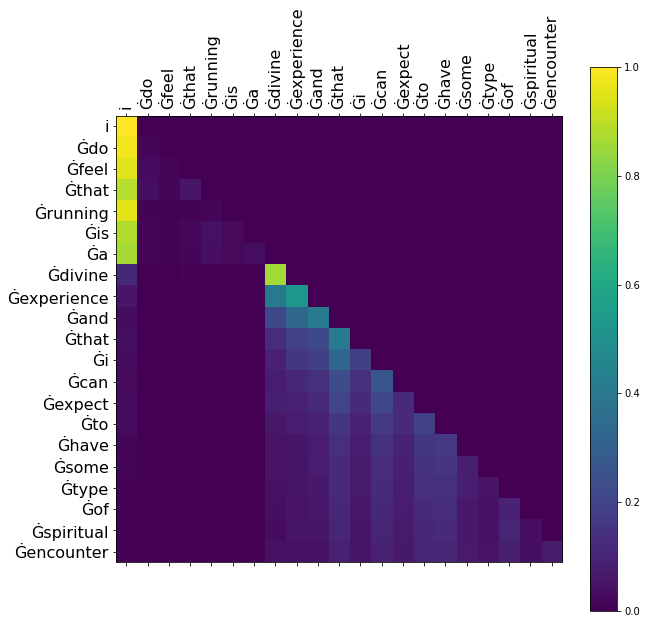

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][1])

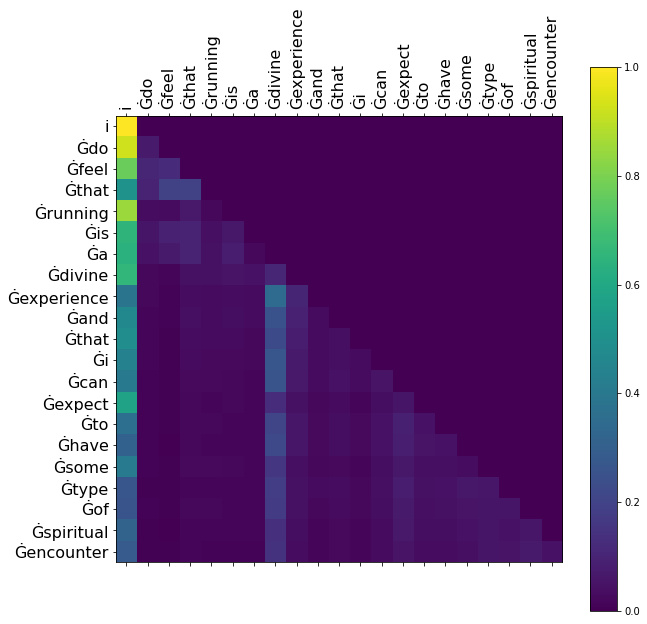

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][3])

In [ ]:
text = emotion_dataset["train"]["text"][11] #tokenizer.decode(result.cpu().flatten().numpy(), skip_special_tokens=True)
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True).to(device)
input_ids = inputs['input_ids']
attention = model_1(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>